In [2]:
#to remove the content in the directory
#!rm /content/EE*

In [1]:
import pydicom
import matplotlib.pylab as plt
import cv2
import glob
import os

from pathlib import Path


In [2]:
image_path = Path('/mnt/c/Users/omera/Desktop/DICOM images')

In [7]:
def download_dicom_images(dicom_folder_path, output_folder_path, patient_id):
    # Download each DICOM file and save it as a PNG image
    for dicom_file in dicom_folder_path.glob("*"):
        # Get the frame number from the DICOM file
        ds = pydicom.dcmread(dicom_file)
        frame_number = int(ds.get_item(("0020", "0012")).value)
        
        # Download the DICOM file and save it as a PNG image
        image = ds.pixel_array
        # Get the left and right end frame from the DICOM file as "l" and "r"
        l, r = int(ds.get_item(("0018", "1602")).value), int(ds.get_item(("0018", "1604")).value)
        
        # Get the name of the PNG image
        image_name = f"Patient_{patient_id}_Image_{l}_{r}_{frame_number}.png"
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        cv2.imwrite(os.path.join(output_folder_path, image_name), image)
        

for patient_path in image_path.glob("*"):
    patient_id = patient_path.parts[-1]
    
    # Upload the DICOM images to notebook
    output_folder_path = Path(f"./output_png_images_{patient_id}")
    output_folder_path.mkdir(exist_ok=True)
    download_dicom_images(patient_path, output_folder_path, patient_id)


In [ ]:
images_ = list(output_folder_path.glob("./*.png"))
images = [None for _ in images_]
for img in images_:
    frame_id = int(img.name.split("_")[-1][:-4])
    images[frame_id-1] = str(img)

import numpy as np
import cv2
clahe = cv2.createCLAHE(clipLimit=4, tileGridSize=(8, 8)) # CLAHE part. ClipLimit and GridSize can change

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, 30.0, (1024,1024))
import numpy as np
for img1, img2 in zip(images[:-1], images[1:]):
    from PIL import Image
    im1 = cv2.imread(img1,-1)
    
    target_size = (1024,1024, 3)
    if im1.shape != target_size:
        print(f"Resizing... {im1.shape} -> {target_size}", end="\r")
        im1 = cv2.resize(im1, dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC)
        
    # im1 = cv2.resize(im1, dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC) / 255 #when the image is not 1024x1024
    
    im1 = im1 / (2**16-1)    # when the image is 1024x1024 there is no need to do resize because we are going to deal with 1024x1024
    
    # image_sums += im1
    # im1 /= np.linalg.norm(im1[:, 292:731, 0].flatten())

    #plt.imshow(((im1 - im2) - np.min((im1 - im2))), cmap="Greys")
    # print(np.min((im1 - im2)), np.max((im1 - im2)))
    #plt.show()
    #print(im1.shape)
    # diff = np.linalg.norm(im1.flatten() - im2.flatten(), axis=0, ord=2, keepdims=False)
    #print(img1, img2, diff)
    # 
    min = im1.min()
    max = im1.max()
    im1 = (((im1 - min) / max) * (2**16-1)).astype(np.uint16)
    # im1[:, 292:731, 0] = clahe.apply(im1[:, 292:731, 0])            # Applying CLAHE but the order of gaussian + Hist Eq + CLAHE can change
    # im1[:, 292:731, 0] = cv2.GaussianBlur(im1[:, 292:731, 0],(5,5),1) # Gaussian Filter Kernel size and sigma value can change
    # im1[:, 292:731, 0] = cv2.equalizeHist(im1[:, 292:731, 0])         # Applying Histogram Equalization  
    # im1[:, 292:731, 0] = hist_eq(im1[:, 292:731, 0])
    # im1[:, 292:731, 0] = clahe.apply(im1[:, 292:731, 0])              # Applying CLAHE
    im1[:, 292:731, 0] = im1[:, 292:731, 0] 
    im1[:, 292:731, 1] = im1[:, 292:731, 0]
    im1[:, 292:731, 2] = im1[:, 292:731, 0]
    plt.imshow(im1 / (2**16 -1))
    raise
    out.write(im1)

out.release()

In [3]:
from pathlib import Path
from collections import defaultdict
import os
images = {}

for input_folder_path in Path(".").glob("output_png_images_*"):
    patient_id = input_folder_path.parts[-1].split("_")[-1]
    image_locations = list(input_folder_path.glob("./*.png"))
    
    images[patient_id] = [None for _ in image_locations]
    # image_locations[0].name.split("_")[1]
    for img_path in image_locations:
        frame_id = int(img_path.name.split("_")[-1][:-4])
        l, r = map(int, img_path.name.split("_")[3:5])
        images[patient_id][frame_id-1] = (str(img_path), patient_id, l, r)

In [33]:

# 8 bit
import numpy as np
import cv2
clahe = cv2.createCLAHE(clipLimit=4, tileGridSize=(8, 8)) # CLAHE part. ClipLimit and GridSize can change

import numpy as np

for patient_id, image in images.items():
    output_folder_path = Path(f"./PreProcessed_8bit_{patient_id}") # 8 bit reading
    output_folder_path.mkdir(exist_ok=True)
    for frame_id, (img, patient_number, l ,r) in enumerate(image, 1):    
        im1 = cv2.imread(img, cv2.IMREAD_GRAYSCALE)   
        
        clahe_image_name = f"Patient_{patient_number}_PreProcessed_Image_{frame_id}.png"
        # im1 = cv2.resize(im1, dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC) / 255 #when the image is not 1024x1024
        target_size = (1024,1024)
        if im1.shape != target_size:
            print(f"Resizing... {im1.shape} -> {target_size}", end="\r")
            l, r = (target_size[0] // im1.shape[0]) * l, (target_size[0] // im1.shape[0]) * r
            im1= cv2.resize(im1, dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC)
            
        im1 = im1 / 255    # when the image is 1024x1024 there is no need to do resize because we are going to deal with 1024x1024
        min = im1.min()
        max = im1.max()
        im1 = (((im1 - min) / max) * 255).astype(np.uint8)
        # im1[:, l:r] = clahe.apply(im1[:, l:r])            # Applying CLAHE but the order of gaussian + Hist Eq + CLAHE can change
        im1[:, l:r] = cv2.GaussianBlur(im1[:, l:r],(5,5),1) # Gaussian Filter Kernel size and sigma value can change
        im1[:, l:r] = cv2.equalizeHist(im1[:, l:r])         # Applying Histogram Equalization  
        im1[:, l:r] = clahe.apply(im1[:, l:r])              # Applying CLAHE
        cv2.imwrite(os.path.join(output_folder_path, clahe_image_name), im1)
        #cv2.imshow(im1)


In [7]:

# 16 bit 
import numpy as np
import cv2
clahe = cv2.createCLAHE(clipLimit=256, tileGridSize=(8, 8)) # CLAHE part. ClipLimit and GridSize can change

import numpy as np

for patient_id, image in images.items():
    output_folder_path = Path(f"./PreProcessed_16bitttt_{patient_id}") # 16 bit reading
    output_folder_path.mkdir(exist_ok=True)
    for frame_id, (img, patient_number, l ,r) in enumerate(image, 1):    
        im1 = cv2.imread(img, -1)   
        
        clahe_image_name = f"Patient_{patient_number}_PreProcessed_Image_{frame_id}.png"
        # im1 = cv2.resize(im1, dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC) / 255 #when the image is not 1024x1024
        target_size = (1024,1024)
        if im1.shape != target_size:
            print(f"Resizing... {im1.shape} -> {target_size}", end="\r")
            l, r = (target_size[0] // im1.shape[0]) * l, (target_size[0] // im1.shape[0]) * r
            im1= cv2.resize(im1, dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC)
            
        im1 = im1.astype(np.float32) / (2**16-1)    # when the image is 1024x1024 there is no need to do resize because we are going to deal with 1024x1024
        min = im1[:, l:r].min()
        max = im1[:, l:r].max()
        im1 = (((im1 - min) / max) * (2**16-1)).astype(np.uint16)
        
        im1[:, l:r] = clahe.apply(im1[:, l:r])            # Applying CLAHE but the order of gaussian + Hist Eq + CLAHE can change
        im1[:, l:r] = cv2.GaussianBlur(im1[:, l:r],(3,3),1) # Gaussian Filter Kernel size and sigma value can change 
        # im1[:, l:r] = clahe.apply(im1[:, l:r])              # Applying CLAHE
        cv2.imwrite(os.path.join(output_folder_path, clahe_image_name), im1)
        #cv2.imshow(im1)


In [12]:
# 16 bit for trying different
import numpy as np
import cv2

for kernel_size, std in zip([3, 3, 5, 5], [0, 1]*3):
    for tilegridsize in [4, 8, 16]:
        for cliplimit in [1,2,4,8,16,32,64,128,256,512,1024]:
            clahe = cv2.createCLAHE(clipLimit=cliplimit, tileGridSize=(tilegridsize, tilegridsize)) # CLAHE part. ClipLimit and GridSize can change

            for patient_id, image in images.items():
                output_folder_path = Path(f"./PreProcessed_16bit_multipleoptions2_{patient_id}") # 16 bit reading
                output_folder_path.mkdir(exist_ok=True)
                for frame_id, (img, patient_number, l ,r) in enumerate(image, 1): 
                    if frame_id != 100:
                        continue
                    im1 = cv2.imread(img, -1)
                    clahe_image_name = f"Patient_{patient_number}_PreProcessed_Image_{frame_id}_clip{cliplimit}_tilegrid{tilegridsize}_kernelsize{kernel_size}_std{std}.png"
                    # im1 = cv2.resize(im1, dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC) / 255 #when the image is not 1024x1024
                    target_size = (1024,1024)
                    if im1.shape != target_size:
                        print(f"Resizing... {im1.shape} -> {target_size}", end="\r")
                        l, r = (target_size[0] // im1.shape[0]) * l, (target_size[0] // im1.shape[0]) * r
                        im1= cv2.resize(im1, dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC)
                    
                
                    
                    im1 = im1.astype(np.float32) / (2**16-1)    # when the image is 1024x1024 there is no need to do resize because we are going to deal with 1024x1024
                    min = im1[:, l:r].min()
                    max = im1[:, l:r].max()
                    im1 = (np.log1p(((im1 - min) / max)) * (2**16-1)).astype(np.uint16)
                    
                    im1[:, l:r] = clahe.apply(im1[:, l:r])              # Applying CLAHE  
                    im1[:, l:r] = cv2.GaussianBlur(im1[:, l:r],(kernel_size,kernel_size),sigmaX=std, sigmaY=std) # Gaussian Filter Kernel size and sigma value can change
                    # im1[:, l:r] = cv2.equalizeHist(im1[:, l:r])         # Applying Histogram Equalization (not needed because CLAHE already does it)
                    # im1[:, l:r] = clahe.apply(im1[:, l:r])            # Applying CLAHE but the order of gaussian + Hist Eq + CLAHE can change

                    cv2.imwrite(os.path.join(output_folder_path, clahe_image_name), im1)
                    


(1024, 439)


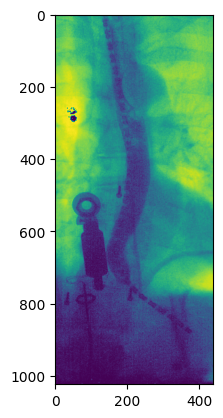

Image Entropy 4.709925060745999


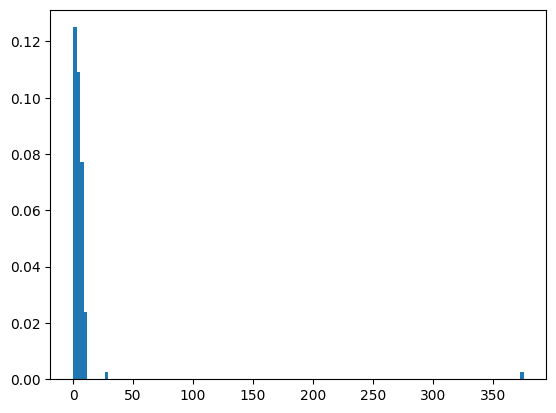

In [74]:
import numpy as np
import cv2
from scipy.stats import entropy
import matplotlib.pyplot as plot
entropy_img_path = "/home/omeralp/tezzzz/PreProcessed_16bit_Clahe4andGauss3_0000E5D9/Patient_0000E5D9_PreProcessed_Image_65.png"
# entropy_img_path = "output_png_images_0000E5D9/Patient_0000E5D9_Image_266_757_65.png"

img_entr = cv2.imread(entropy_img_path, -1)[:,292:731]

def reject_outliers(data, m=2):
    shape = data.shape
    data = data.flatten()
    data[abs(data - np.mean(data)) > m * np.std(data)] = 0
    return data.reshape(shape)

print(img_entr.shape)
img_entr = reject_outliers(img_entr)
plot.imshow(img_entr)
plot.show()
_bins = 128

hist, _ = np.histogram(img_entr.ravel(), bins=_bins, range=(0, _bins))
prob_dist = hist / hist.sum()
image_entropy = entropy(prob_dist, base=2)
print(f"Image Entropy {image_entropy}")
plot.hist(hist, density=1, bins=_bins)

plot.show()

In [50]:
import cv2
import numpy as np


def calcEntropy(img):
    entropy = []

    hist = cv2.calcHist([img], [0], None, [256], [0, 255])
    total_pixel = img.shape[0] * img.shape[1]

    for item in hist:
        probability = item / total_pixel
        if probability == 0:
            en = 0
        else:
            en = -1 * probability * (np.log(probability) / np.log(2))
        entropy.append(en)

    sum_en = np.sum(entropy)
    return sum_en


if __name__ == '__main__':
    img1 = cv2.imread("/home/omeralp/tezzzz/PreProcessed_8bit_0000E5D9/Patient_0000E5D9_PreProcessed_Image_12.png", cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread("/home/omeralp/tezzzz/PreProcessed_8bit_0000E5D9/Patient_0000E5D9_PreProcessed_Image_92.png", cv2.IMREAD_GRAYSCALE)

    entropy1 = calcEntropy(img1)
    entropy2 = calcEntropy(img2)

    print(entropy1)
    print(entropy2)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (256,) + inhomogeneous part.

In [19]:
# only to change file names for 07.02.2024
from pathlib import Path
import os
input_folder_path = Path("/home/omeralp/tezzzz/output_png_images_2")
output_folder_path = Path("/home/omeralp/tezzzz/Patient_2_CLAHE_clipLimit1024_tileGrid8_Gauss_kernel3_sigma1")
image_locations = list(input_folder_path.glob("./*.png"))
images = [None for _ in image_locations]
output_folder_path.mkdir(exist_ok=True)
# image_locations[0].name.split("_")[1]
for img_path in image_locations:
    frame_id = int(img_path.name.split("_")[-1][:-4])
    images[frame_id-1] = (str(img_path), int(img_path.name.split("_")[1]))

In [18]:
# creating the files and trial for different clahes and gaussian. Date: 07.02.2024
import numpy as np
import cv2

clahe = cv2.createCLAHE(clipLimit=1024, tileGridSize=(8, 8)) # CLAHE part. ClipLimit and GridSize can change

import numpy as np
for frame_id, (img, patient_number) in enumerate(images, 1):    
    im1 = cv2.imread(img, -1)[... , 0]   
    clahe_image_name = f"Patient_{patient_number}_clip1024_tile8_kernel3_sigma1_{frame_id}.png"
    # im1 = cv2.resize(im1, dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC) / 255 #when the image is not 1024x1024
    target_size = (1024,1024)
    if im1.shape != target_size:
        print(f"Resizing... {im1.shape} -> {target_size}", end="\r")
        im1= cv2.resize(im1, dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC)
    
   
    
    im1 = im1.astype(np.float32) / (2**16-1)    # when the image is 1024x1024 there is no need to do resize because we are going to deal with 1024x1024
    min = im1[:, 292:731].min()
    max = im1[:, 292:731].max()
    im1 = (((im1 - min) / max) * (2**16-1)).astype(np.uint16)
    
    im1[:, 292:731] = clahe.apply(im1[:, 292:731])              # Applying CLAHE 
    # im1[:, 292:731, 0] = clahe.apply(im1[:, 292:731, 0])            # Applying CLAHE but the order of gaussian + Hist Eq + CLAHE can change
    im1[:, 292:731] = cv2.GaussianBlur(im1[:, 292:731],(3,3),sigmaX=1, sigmaY=1) # Gaussian Filter Kernel size and sigma value can change
    # im1[:, 292:731, 0] = cv2.equalizeHist(im1[:, 292:731, 0])         # Applying Histogram Equalization 
    # im1[:, 292:731] = hist_eq(im1[:, 292:731])           
    
    cv2.imwrite(os.path.join(output_folder_path, clahe_image_name), im1)
    #cv2.imshow(im1)


In [26]:
#high pass filter trial 05.02.2024
im1_gaussian = cv2.GaussianBlur(im1[:, 292:731],(3,3),sigmaX=1, sigmaY=1)
weight_factor = 0.5 # in between 0-1
first_var = weight_factor * im1_gaussian
im1 = im1 - first_var

ValueError: operands could not be broadcast together with shapes (1024,1024) (1024,439) 

In [51]:
# only trial for 04.02.2024 and 06.02.2024
import numpy as np
import cv2

clahe = cv2.createCLAHE(clipLimit=0.4, tileGridSize=(4, 4)) # CLAHE part. ClipLimit and GridSize can change
weight_factor = 0.1 # in between 0-1
import numpy as np
for frame_id, (img, patient_number) in enumerate(images, 1):    
    im1 = cv2.imread(img, -1)[... , 0]
    # im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)   
    clahe_image_name = f"Patient_{patient_number}_PreProcessed_Image_{frame_id}.png"
    # im1 = cv2.resize(im1, dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC) / 255 #when the image is not 1024x1024
    target_size = (1024,1024)
    if im1.shape != target_size:
        print(f"Resizing... {im1.shape} -> {target_size}", end="\r")
        im1= cv2.resize(im1, dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC)
    
   
    
    im1 = im1.astype(np.float32) / (2**16-1)    # when the image is 1024x1024 there is no need to do resize because we are going to deal with 1024x1024
    min = im1[:, 292:731].min()
    max = im1[:, 292:731].max()
    im1 = (((im1 - min) / max) * (2**16-1)).astype(np.uint16)
    # im1 = cv2.cvtColor(im1, COLOR_BGR2GRAY)

    # im1[:, 292:731] = clahe.apply(im1[:, 292:731])            # Applying CLAHE but the order of gaussian + Hist Eq + CLAHE can change
    # im1[:, 292:731] = cv2.GaussianBlur(im1[:, 292:731],(5,5),sigmaX=1, sigmaY=1) # Gaussian Filter Kernel size and sigma value can change
    convolved = cv2.GaussianBlur(im1[:, 292:731],(5,5),sigmaX=3, sigmaY=3)
    # im1[:, 292:731, 0] = cv2.equalizeHist(im1[:, 292:731, 0])         # Applying Histogram Equalization 
    # im1[:, 292:731] = hist_eq(im1[:, 292:731])      
    im1[:, 292:731] = (im1[:, 292:731] - weight_factor * convolved).astype(np.uint16)
    im1[:, 292:731] = clahe.apply(im1[:, 292:731])    
    # im1[:, 292:731] = clahe.apply(im1[:, 292:731])              # Applying CLAHE 
    cv2.imwrite(os.path.join(output_folder_path, clahe_image_name), im1)
    # cv2.imwrite(os.path.join(output_folder_path, clahe_image_name), im1)
    #cv2.imshow(im1)

In [ ]:
import os
import glob
import shutil
from pathlib import Path
def preprocess_images(input_dir, output_dir, preprocessing_function):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in glob.glob(os.path.join(input_dir, '*')):
        if filename.endswith('.png'):
            path = os.path.join(input_dir, filename)
            with open(path, 'rb') as f:
                image = f.read()

            # Extract patient ID and image number from filename
            patient_id, image_num = filename.split('_')[:2]
            image_num = int(image_num)

            # Apply preprocessing function
            preprocessed_image = preprocessing_function(image)

            # Construct new filename
            new_filename = f'{patient_id}_Preprocessed_{image_num:03d}.png'

            # Save the preprocessed image
            with open(os.path.join(output_dir, new_filename), 'wb') as f:
                f.write(preprocessed_image)

# Replace `preprocessing_function` with your own preprocessing function
preprocessing_function = lambda image: image

# Specify the input and output directories
input_dir = Path("/home/omeralp/tezzzz/output_png_images_5")
output_dir = Path("/home/omeralp/tezzzz/PreProcessed_images_5")

# Preprocess the images and save them to the output directory
preprocess_images(input_dir, output_dir, preprocessing_function)


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
# Read the preprocessed X-ray image
image = cv2.imread('normalized_xray.png', 0)

# Apply edge detection to identify sensor edges
edges = cv2.Canny(image, 50, 150)

# Apply morphological operations to isolate sensor regions
dilated_edges = cv2.dilate(edges, (5, 5), iterations=1)
eroded_edges = cv2.erode(dilated_edges, (5, 5), iterations=1)

# Apply connected component labeling to segment individual sensors
contours, _ = cv2.findContours(eroded_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Label each sensor region with a unique identifier
sensor_labels = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    sensor_label = str(len(sensor_labels) + 1)
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
    cv2.putText(image, sensor_label, (x + w // 2, y + h // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    sensor_labels.append(sensor_label)

# Display the labeled image
print("labeled image")
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
from src.algorithms.base import BaseAlgorithm
import src.utils as pu

import numpy as np
import imageio
import matplotlib.pyplot as plt
import os
import timeit

from collections import Counter

class CLAHE(BaseAlgorithm):
	'''Contrast Limited Adaptive Histogram Equalization.
	In reality, we do a normalization before applying CLAHE, making it the N-CLAHE method, but in
	N-CLAHE the normalization is done using a log function, instead of a linear one, as we use here.
	'''

	def __init__(self, filename, results_path):
		self.filename = filename
		self.results_path = results_path
		self.get_input()

	def run(self):
		image = imageio.imread(self.filename)

		if len(image.shape) > 2:
			image = pu.to_grayscale(image)

		normalized_image = pu.normalize(np.min(image), np.max(image), 0, 255, image)
		imageio.imwrite(os.path.join(self.results_path, "normalized_image.jpg"), normalized_image)

		start = timeit.default_timer()
		equalized_image = self.clahe(normalized_image)
		stop = timeit.default_timer()

		self.export_histogram(image, normalized_image, equalized_image)
		self.export_run_info(stop - start)

		return equalized_image

	def get_input(self):
		print("Window size: ")
		self.window_size = int(input())
		print("Clip limit: ")
		self.clip_limit = int(input())
		print("Number of iterations: ")
		self.n_iter = int(input())

	def clahe(self, image):
		'''Applies the CLAHE algorithm in an image.

		Parameters:
			image: image to be processed.

		Returns a processed image.
		'''

		border = self.window_size // 2

		padded_image = np.pad(image, border, "reflect")
		shape = padded_image.shape
		padded_equalized_image = np.zeros(shape).astype(np.uint8)

		for i in range(border, shape[0] - border):
			if i % 50 == 0:
				print(f"Line: {i}")
			for j in range(border, shape[1] - border):
				# Region to extract the histogram
				region = padded_image[i-border:i+border+1, j-border:j+border+1]
				# Calculating the histogram from region
				hist, bins = pu.histogram(region)
				# Clipping the histogram
				clipped_hist = pu.clip_histogram(hist, bins, self.clip_limit)
				# Trying to reduce the values above clipping
				for _ in range(self.n_iter):
					clipped_hist = pu.clip_histogram(hist, bins, self.clip_limit)
				# Calculating the CDF
				cdf = pu.calculate_cdf(hist, bins)
				# Changing the value of the image to the result from the CDF for the given pixel
				padded_equalized_image[i][j] = cdf[padded_image[i][j]]

		# Removing the padding from the image
		equalized_image = padded_equalized_image[border:shape[0] - border, border:shape[1] - border].astype(np.uint8)

		return equalized_image

	def clipped_histogram_equalization(self, region):
		'''Calculates the clipped histogram equalization for the given region.

		Parameters:
			region: array-like.

		Returns a dictionary with the CDF for each pixel in the region.
		'''

		# Building the histogram
		hist, bins = pu.histogram(region)
		n_bins = len(bins)

		# Removing values above clip_limit
		excess = 0
		for i in range(n_bins):
			if hist[i] > self.clip_limit:
				excess += hist[i] - self.clip_limit
				hist[i] = self.clip_limit

		## Redistributing exceding values ##
		# Calculating the values to be put on all bins
		for_each_bin = excess // n_bins
		# Calculating the values left
		leftover = excess % n_bins

		hist += for_each_bin
		for i in range(leftover):
			hist[i] += 1

		# Calculating probability for each pixel
		pixel_probability = hist / hist.sum()
		# Calculating the CDF (Cumulative Distribution Function)
		cdf = np.cumsum(pixel_probability)

		cdf_normalized = cdf * 255

		hist_eq = {}
		for i in range(len(cdf)):
			hist_eq[bins[i]] = int(cdf_normalized[i])

		return hist_eq

	def export_histogram(self, image, normalized, equalized):
		plt.xlabel("Pixel")
		plt.ylabel("Count")

		hist, bins = pu.histogram(image)
		plt.plot(bins, hist, label='Original Image')
		plt.legend()

		hist, bins = pu.histogram(normalized)
		plt.plot(bins, hist, label='Normalized Image')
		plt.legend()

		hist, bins = pu.histogram(equalized)
		plt.plot(bins, hist, label='CLAHE Result')
		plt.legend()
		plt.savefig(os.path.join(self.results_path, "histograms.jpg"))

	def export_run_info(self, runtime):
		with open(os.path.join(self.results_path, "runinfo.txt"), 'w+') as f:
			f.write(f"Runtime: {runtime:.2f}s\n")
			f.write(f"Window size: {self.window_size}\n")
			f.write(f"Clip limit: {self.clip_limit}\n")

ModuleNotFoundError: ignored

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

def adaptive_threshold(image_path, block_size=9, constant=3):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply GaussianBlur to reduce noise and improve results
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # Apply adaptive thresholding
    threshold_img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, constant)

    # Display the original and thresholded images
    print("original image")
    cv2_imshow(img)
    print("adaptive image")
    cv2_imshow(threshold_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example usage:
# Provide the path to your X-ray image
image_path = '/content/denemeimage.png'
adaptive_threshold(image_path)


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

def adaptive_threshold(img, window_size, t):
    h, w = img.shape
    int_img = np.zeros((h, w), dtype=np.int32)

    # Calculate integral image
    for i in range(w):
        _sum = 0
        for j in range(h):
            _sum += img[i, j]
            if i == 0:
                int_img[i, j] = _sum
            else:
                int_img[i, j] = int_img[i - 1, j] + _sum

    # Apply adaptive thresholding
    result_img = np.zeros_like(img, dtype=np.uint8)

    for i in range(w):
        for j in range(h):
            x1 = max(0, i - window_size // 2)
            x2 = min(w - 1, i + window_size // 2)
            y1 = max(0, j - window_size // 2)
            y2 = min(h - 1, j + window_size // 2)

            count = (x2 - x1) * (y2 - y1)
            _sum = int_img[x2, y2] - int_img[x2, y1 - 1] - int_img[x1 - 1, y2] + int_img[x1 - 1, y1 - 1]

            if img[i, j] * count <= _sum * (100 - t) / 100:
                result_img[i, j] = 0
            else:
                result_img[i, j] = 255

    return result_img

# Example usage:
# Assuming 'input_img' is your input image (numpy array)
# Set the window size and threshold 't' according to your requirements
window_size = 3
threshold = 10
output_img = adaptive_threshold(imge, window_size, threshold)
cv2_imshow(output_img)


image result


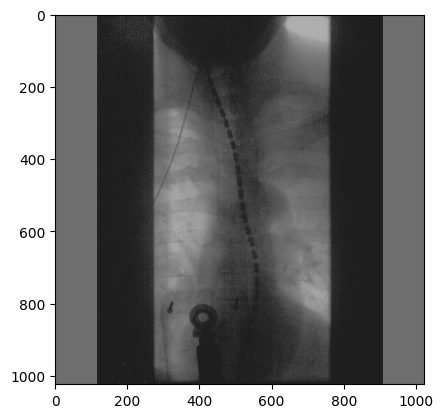

-1

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# Load the grayscale X-ray image
image = cv2.imread('/content/denemeimage.png', cv2.IMREAD_GRAYSCALE)

# Apply adaptive thresholding to separate dark areas from sensors
thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 15)

# Perform morphological operations to remove small noise and connect regions
kernel = np.ones((5, 5), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

# Apply edge detection to identify potential sensor boundaries
edges = cv2.Canny(closing, 50, 150)

# Employ Hough Circles transform to detect circular shapes, which are likely to be sensors
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 20, minRadius=10, maxRadius=50)

# Extract the coordinates of detected sensors
sensor_locations = []
if circles is not None:
    for circle in circles[0, :]:
        x, y, r = circle
        sensor_locations.append((x, y))

# Overlay the detected sensor locations onto the original image
for x, y in sensor_locations:
    cv2.circle(image, (int(x), int(y)), 10, (0, 255, 0), -1)

# Display the annotated image
print("image result")
cv2_imshow(image)
cv2.waitKey(0)

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
image_path = '/content/EE0B8F74'
print("original image")
ds = dicom.dcmread(image_path)
img = ds.pixel_array
cv2_imshow(img)
print(img.shape)
print(type(img.shape))

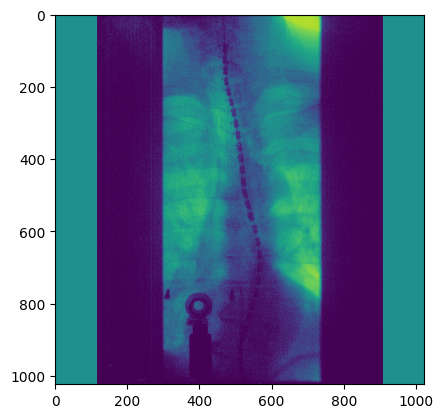

In [ ]:
import pydicom as dicom
import PIL # optional
import pandas as pd
import matplotlib.pyplot as plt

# specify your image path
image_path = '/content/EE0B8F74'
ds = dicom.dcmread(image_path)
plt.imshow( ds.pixel_array)

plt.show()

In [ ]:
import pydicom as dicom
import os
import cv2
import PIL # optional
# make it True if you want in PNG format
PNG = False
# Specify the .dcm folder path
folder_path = "/content/EE0B8F74"
# Specify the output jpg/png folder path
jpg_folder_path = "JPG_test"
images_path = os.listdir(folder_path)
for n, image in enumerate(images_path):
    ds = dicom.dcmread(os.path.join(folder_path, image))
    pixel_array_numpy = ds.pixel_array
    if PNG == False:
        image = image.replace('.dcm', '.jpg')
    else:
        image = image.replace('.dcm', '.png')
    cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)
    if n % 50 == 0:
        print('{} image converted'.format(n))

NotADirectoryError: ignored

In [ ]:
pip install opencv-python

original image


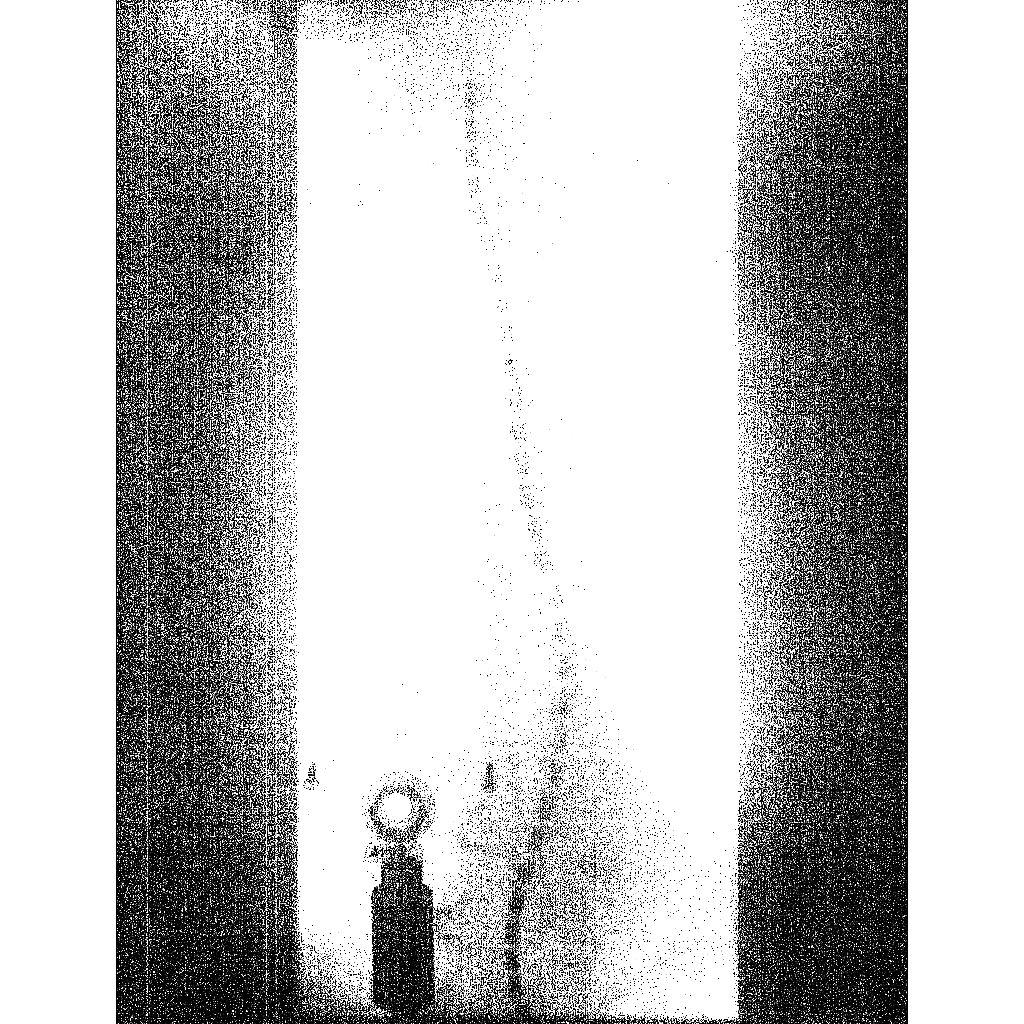

enhanced image


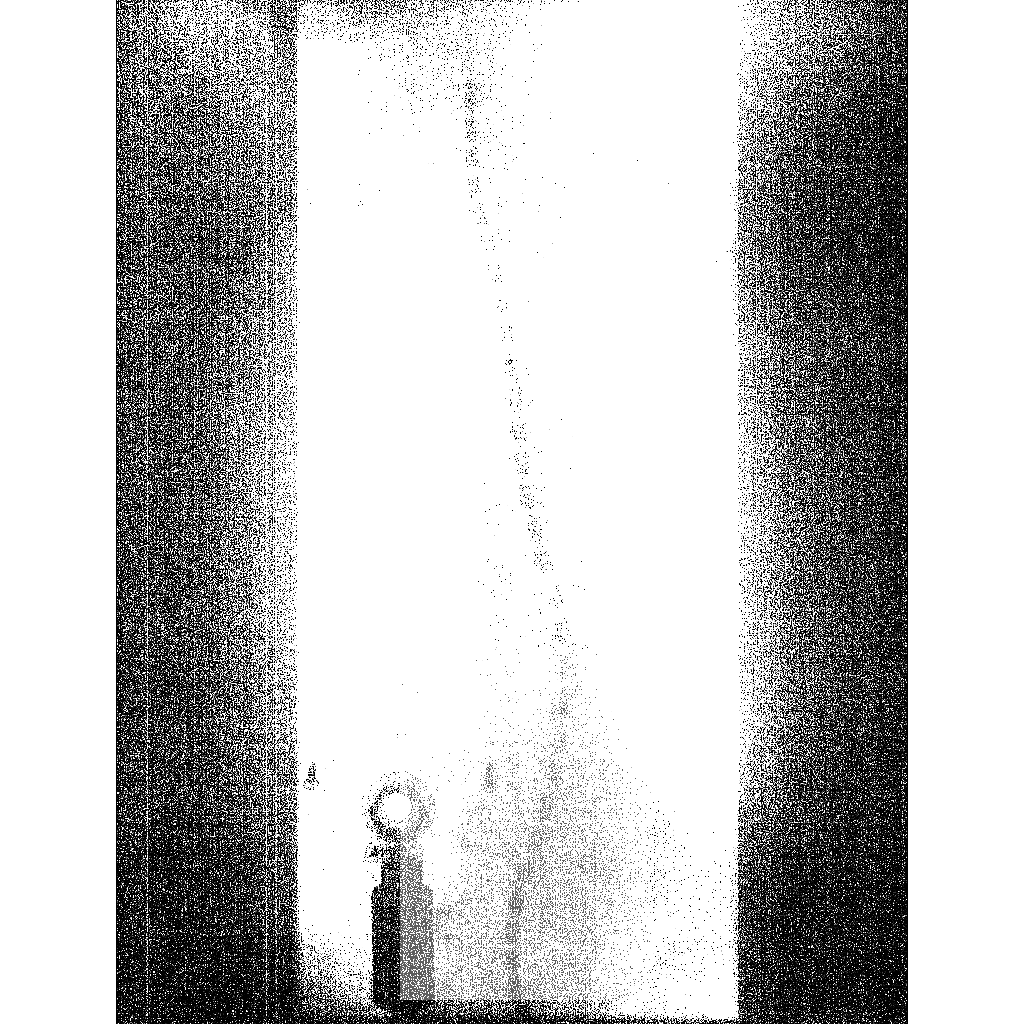

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

def enhance_roi_with_clahe(image, roi_coordinates):
    # Convert image to grayscale if it's in color
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=0.1, tileGridSize=(8, 8))

    # Enhance the ROI with CLAHE
    enhanced_roi = clahe.apply(image[roi_coordinates[1]:roi_coordinates[3], roi_coordinates[0]:roi_coordinates[2]])

    # Copy the original image and replace the ROI with the enhanced version
    enhanced_image = image.copy()
    enhanced_image[roi_coordinates[1]:roi_coordinates[3], roi_coordinates[0]:roi_coordinates[2]] = enhanced_roi

    return enhanced_image

# Example usage:
# Provide the path to your X-ray image

original_image = img

# Define ROI coordinates (x1, y1, x2, y2)
roi_coordinates = (400, 650, 650, 1000)

# Enhance the ROI with CLAHE
enhanced_image = enhance_roi_with_clahe(original_image, roi_coordinates)

# Display the original and enhanced images
print("original image")
cv2_imshow(original_image)
print("enhanced image")
cv2_imshow(enhanced_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

original image


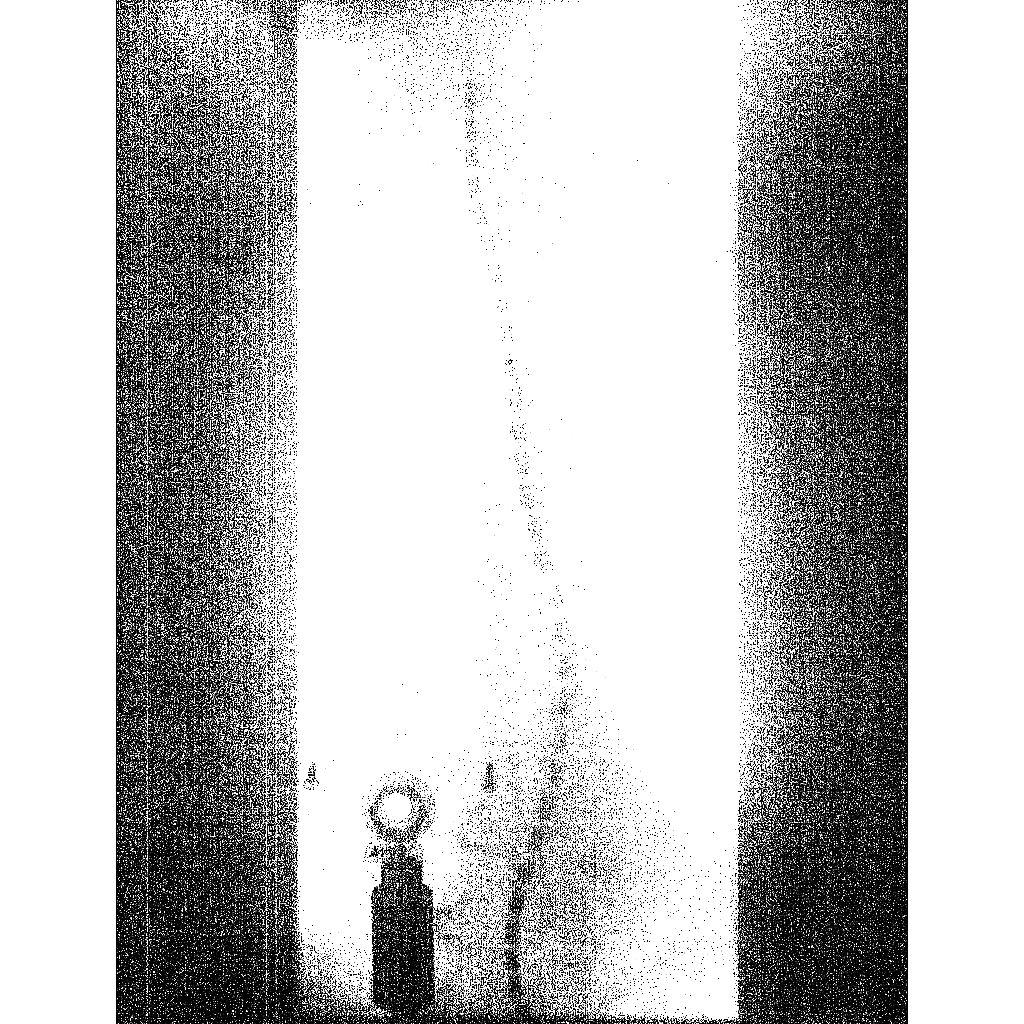

enhanced image


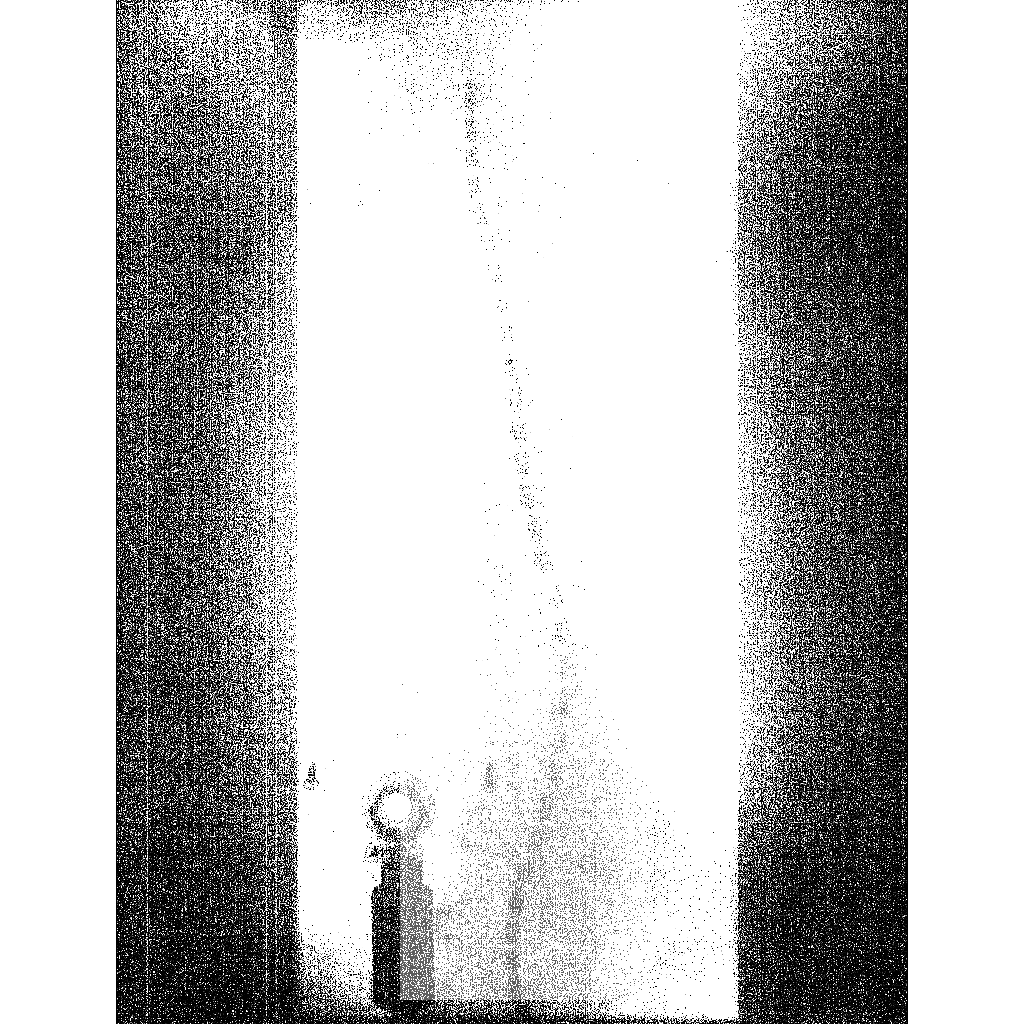

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

def enhance_roi_with_clahe(image, roi_coordinates):


    # Create a CLAHE object with more parameters
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))

    # Enhance the ROI with CLAHE
    enhanced_roi = clahe.apply(image[roi_coordinates[1]:roi_coordinates[3], roi_coordinates[0]:roi_coordinates[2]])

    # Copy the original image and replace the ROI with the enhanced version
    enhanced_image = image.copy()
    enhanced_image[roi_coordinates[1]:roi_coordinates[3], roi_coordinates[0]:roi_coordinates[2]] = enhanced_roi

    return enhanced_image

# Example usage:
# Provide the path to your X-ray image

original_image = img

# Define ROI coordinates (x1, y1, x2, y2)
roi_coordinates = (400, 650, 650, 1000)

# Enhance the ROI with CLAHE
enhanced_image = enhance_roi_with_clahe(original_image, roi_coordinates)

# Display the original and enhanced images
print("original image")
cv2_imshow(original_image)
print("enhanced image")
cv2_imshow(enhanced_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


(1024, 1024)
<class 'tuple'>


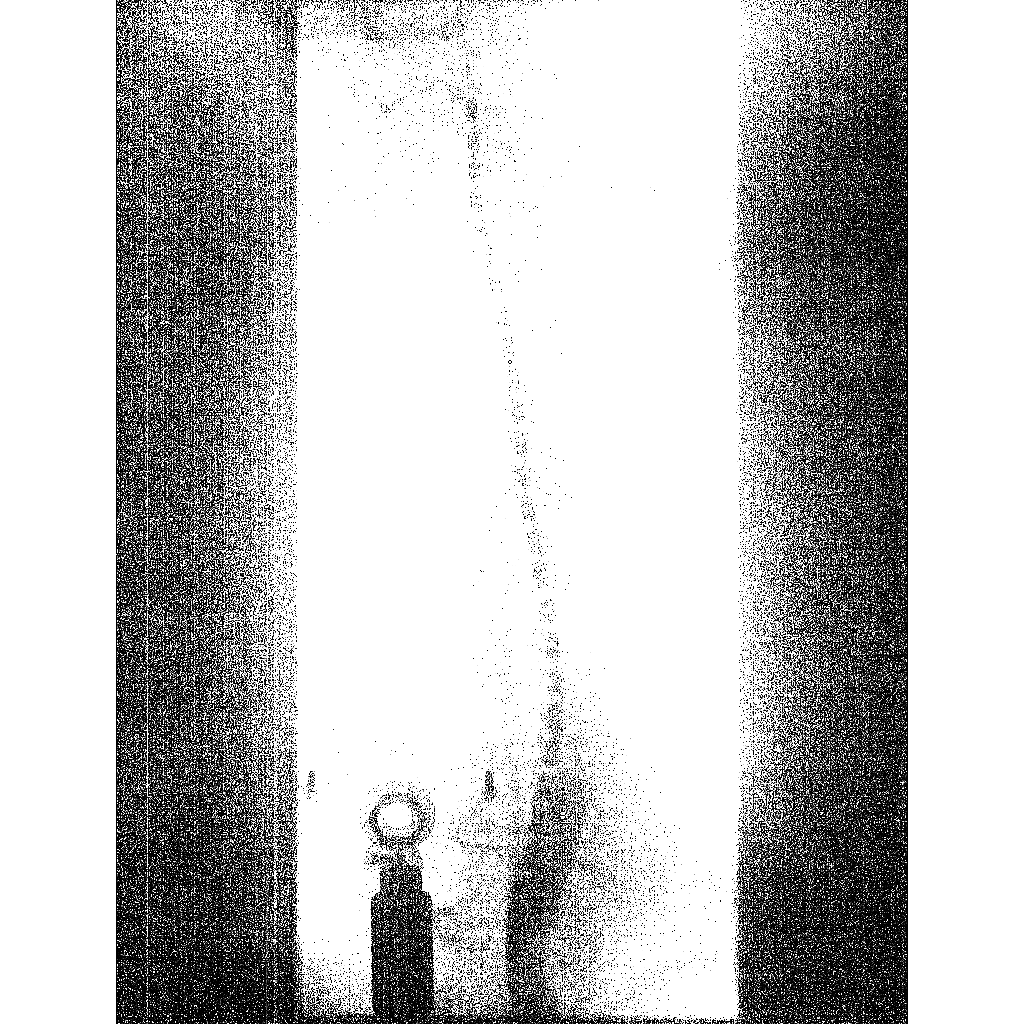

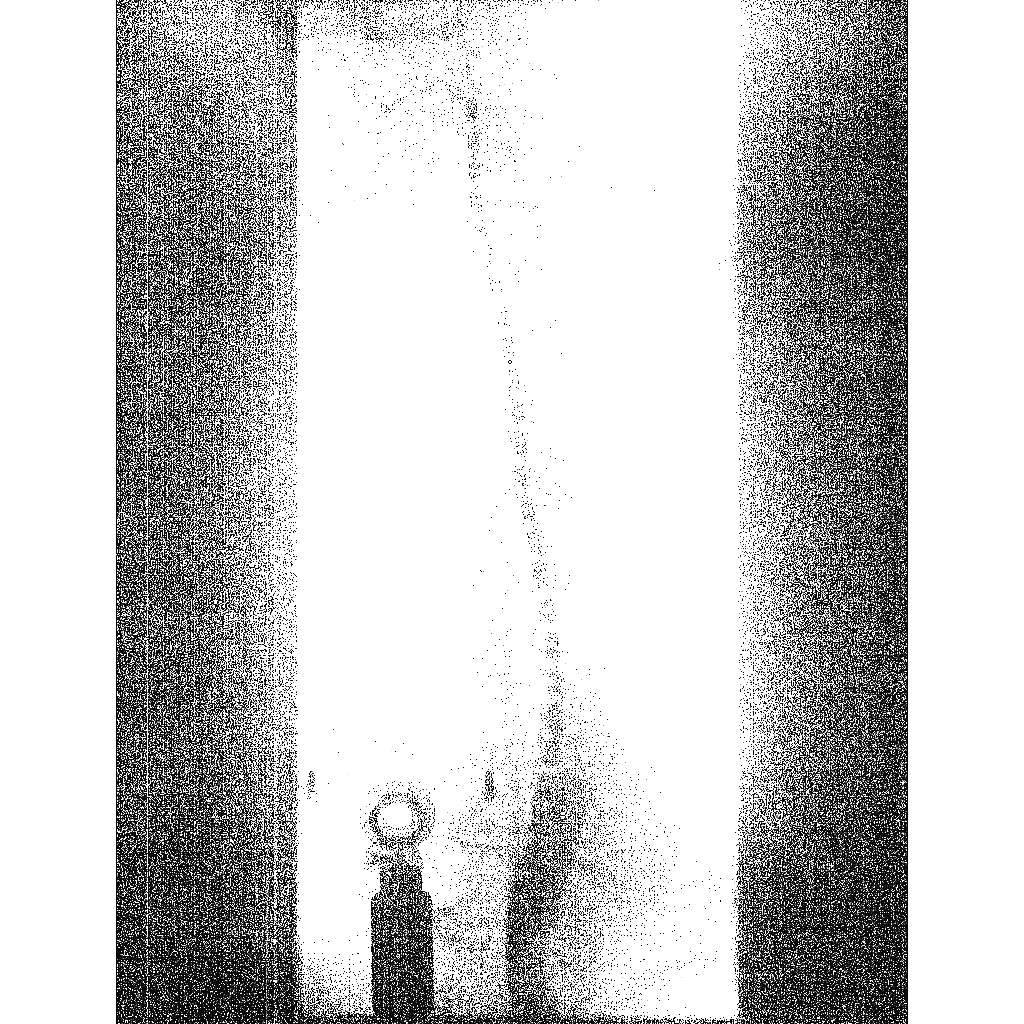

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
image_path = '/content/EE00AE08'
ds = dicom.dcmread(image_path)
img = ds.pixel_array
#plt.imshow(ds.pixel_array)
print(img.shape)
print(type(img.shape))
def clahe(image, clip_limit=0.01, tile_size=(8, 8)):
    # Apply CLAHE to each channel separately
    clahe_applied = [cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_size).apply(channel) for channel in cv2.split(image)]

    # Merge the channels back together
    clahe_image = cv2.merge(clahe_applied)

    return clahe_image

# Example usage:
# Read your image (assuming it is not RGB, for example, a single-channel grayscale image)
image = img

# Apply CLAHE
clahe_applied = clahe(image)

# Display the original and enhanced images
cv2_imshow(image)
cv2_imshow(clahe_applied)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import cv2

def enhance_image(image_path):
    # Load the X-ray image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(img)

    # Display the original and enhanced images
    cv2.imshow('Original Image', img)
    cv2.imshow('Enhanced Image', enhanced_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Provide the path to your X-ray image
image_path = '/content/EE0A8C12'
enhance_image(image_path)

In [ ]:
# bhattacharyya Distance ---- Pek çalışmıyo gibi geldi bana


import numpy as np
#from scipy.stats import bhattacharyya

import math


def bhattacharyya(a, b):
    """ Bhattacharyya distance between distributions (lists of floats). """
    if not len(a) == len(b):
        raise ValueError("a and b must be of the same size")
    return -math.log(sum((math.sqrt(u * w) for u, w in zip(a, b))))


def calculate_bhattacharyya_distance(hist1, hist2):
    # Ensure histograms are numpy arrays
    hist1 = np.array(hist1)
    hist2 = np.array(hist2)

    # Normalize histograms
    hist1 = hist1 / np.sum(hist1)
    hist2 = hist2 / np.sum(hist2)

    # Calculate Bhattacharyya Distance
    distance = bhattacharyya(hist1, hist2)

    return distance

# Example usage:
# Assuming hist1 and hist2 are the histograms of two images
hist1 = np.histogram(image1.flatten(), bins=256, range=(0, 1))[0]
hist2 = np.histogram(image2.flatten(), bins=256, range=(0, 1))[0]

bhattacharyya_distance = calculate_bhattacharyya_distance(hist1, hist2)

print("Bhattacharyya Distance:", bhattacharyya_distance)


Bhattacharyya Distance: 6.705791662154043e-06


In [ ]:
### Dümdüz MSE error, imagelerde işe yarar mı bilmiyorum

import numpy as np
from skimage.metrics import mean_squared_error

image1 = cv2.imread('/content/distance_1.png', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('/content/distance_2.png', cv2.IMREAD_GRAYSCALE)

mse = mean_squared_error(image1, image2)
print("Mean Squared Error:", mse)


Mean Squared Error: 13.549684524536133
